In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df_trombose=pd.read_csv("pre_processing_trombose.csv")
df_trombose.head()

,aCL IgG,aCL IgM,ANA,aCL IgA,KCT,RVVT,LAC,D_ANA Pattern,N_ANA Pattern,P_ANA Pattern,...,polyarthralgia_Diagnosis,preg_Diagnosis,protein loosing _Diagnosis,pulmonary emboli_Diagnosis,thrombocytopenia_Diagnosis,uveitis_Diagnosis,varix_Diagnosis,vasculitis_Diagnosis,vertigo_Diagnosis,Thrombosis
0,-0.14372,-0.04686,-0.22861,-0.04934,0.31858,0.35398,0.00000,0.00000,0.00000,1.00000,...,0,0,0,0,0,0,0,0,0,1
1,-0.12367,-0.04651,-0.22861,-0.04787,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0,0,0,0,0,0,0,0,0,0
2,-0.13704,-0.04676,-0.46242,-0.04778,0.31858,0.35398,0.37931,0.01918,0.00548,0.51507,...,0,0,0,0,0,0,0,0,0,0
3,-0.15241,-0.04658,-0.45876,-0.04934,0.31858,0.35398,0.37931,0.00000,0.00000,1.00000,...,0,0,0,0,0,0,0,0,1,0
4,-0.14573,-0.04677,0.47282,-0.04934,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import accuracy_score, precision_score, f1_score


import itertools

#AdaBoost
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from collections import Counter
from imblearn.datasets import fetch_datasets
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


## Identificando atributos e variáveis-alvo

In [4]:
#Extrair colunas dos atributos
feature_cols = list(df_trombose.columns[:-1])

#Extrair as variáveis-alvo
target_col = df_trombose.columns[-1]

#Mostrar a lista de colunas
print "Colunas de atributo:\n{}".format(feature_cols)
print "\n Variável-alvo: {}".format(target_col)

#Separar os dados entre atributos e target
X_all = df_trombose[feature_cols]
y_all = df_trombose[target_col]


Colunas de atributo:
['aCL IgG', 'aCL IgM', 'ANA', 'aCL IgA', 'KCT', 'RVVT', 'LAC', 'D_ANA Pattern', 'N_ANA Pattern', 'P_ANA Pattern', 'S_ANA Pattern', 'ABN_Diagnosis', 'AGA_Diagnosis', 'AIHA_Diagnosis', 'AMI_Diagnosis', 'AP_Diagnosis', 'APS_Diagnosis', 'APTT Elongation_Diagnosis', 'ARF_Diagnosis', 'Adult Still_Diagnosis', 'Amyopathic_Diagnosis', 'Aortitis_Diagnosis', 'BFP_Diagnosis', 'BOOP_Diagnosis', 'Basedow_Diagnosis', 'Behcet_Diagnosis', 'Bleeding Colitis_Diagnosis', 'Budd-Chiari_Diagnosis', 'CNS_Diagnosis', 'Cervical Lymphotidis_Diagnosis', 'Chorea_Diagnosis', 'Cliogloblin_Diagnosis', 'Crohn_Diagnosis', 'Cryoglobulin_Diagnosis', 'DLE_Diagnosis', 'DM_Diagnosis', 'DVT_Diagnosis', 'EB_Diagnosis', 'EN_Diagnosis', 'FLD_Diagnosis', 'FUO_Diagnosis', 'HLP_Diagnosis', 'HT_Diagnosis', 'Hashimoto_Diagnosis', 'IP_Diagnosis', 'IPH_Diagnosis', 'ITP_Diagnosis', 'JRA_Diagnosis', 'LA_Diagnosis', 'LAC_Diagnosis', 'LIVER D_Diagnosis', 'Livedo_Diagnosis', 'MCTD_Diagnosis', 'MRA_Diagnosis', 'NS_Diagn

In [5]:
#Função criada por https://www.kaggle.com/joparga3
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        1
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred, average=None)))
    print("recall: {}".format(recall_score(true_value, pred, average=None)))
    print("f1: {}".format(f1_score(true_value, pred, average=None)))

### Separando pontos de Treinamento e Teste

In [7]:
#Número de pontos de treinamento 70% Treinamento, 30% Teste
#329 treinamento, 141 teste  

#Embaralhar e distribuir o conjunto de dados
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify=y_all, test_size=0.3, random_state=2)

#Mostrar resultado da distribuição
print "O conjunto de treinamento tem {} amostras".format(X_train.shape[0])
print "O conjunto de teste tem {} amostras".format(X_test.shape[0])

O conjunto de treinamento tem 332 amostras
O conjunto de teste tem 143 amostras


## Treinamento utilizando Classificação AdaBoost

In [8]:
#Aplicando AdaBoost
dt = DecisionTreeClassifier()
clf = AdaBoostClassifier(n_estimators=150, base_estimator=dt, learning_rate=1)

clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

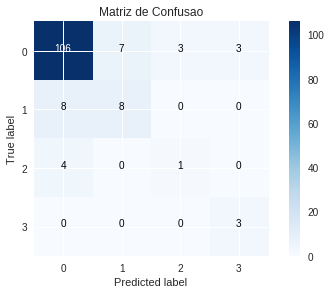

AdaBoost
accuracy: 0.825174825175
precision: [ 0.9   0.53  0.25  0.5 ]
recall: [ 0.89  0.5   0.2   1.  ]
f1: [ 0.89  0.52  0.22  0.67]


In [9]:
#Computar matriz de confusão
cnf_matrix = confusion_matrix(y_test, prediction)
np.set_printoptions(precision=2)


#Plot matriz de confusão
class_names = [0,1,2,3]
plt.figure()
plot_confusion_matrix(cnf_matrix,
                     classes = class_names,
                     title='Matriz de Confusao')

plt.show()

print_results("AdaBoost", y_test,prediction)

# Resampling 

In [10]:
#Numero de dados na classe minoritária
number_trombose = len(df_trombose[df_trombose['Thrombosis']==3])
trombose_indices = np.array(df_trombose[df_trombose['Thrombosis']==3].index)

#Array com 5 dados aleatórios da classe 0
normal_indices = df_trombose[df_trombose['Thrombosis']==0].index
random_normal_indices = np.random.choice(normal_indices, number_trombose, replace=False)
random_normal_indices = np.array(random_normal_indices)

#Array com 5 dados aleatórios da classe 1
normal_indices = df_trombose[df_trombose['Thrombosis']==1].index
random_normal_indices1 = np.random.choice(normal_indices, number_trombose, replace=False)
random_normal_indices1 = np.array(random_normal_indices1)

#Array com 5 dados aleatórios da classe 2
normal_indices = df_trombose[df_trombose['Thrombosis']==2].index
random_normal_indices2 = np.random.choice(normal_indices, number_trombose, replace=False)
random_normal_indices2 = np.array(random_normal_indices2)

#concatena o conjunto de indices selecionados das 4 classes
under_sample_indices = np.concatenate([trombose_indices,random_normal_indices,random_normal_indices1,random_normal_indices2])

#Cria dataframe com dados correspondente aos índices
under_sample_data = df_trombose.iloc[under_sample_indices,:]

#Cria undersample com todos os atributos
X_undersample = under_sample_data.iloc[:,under_sample_data.columns != 'Thrombosis']

#Cria undersample com target
y_undersample = under_sample_data.iloc[:,under_sample_data.columns == 'Thrombosis']

print("Porcentagem da classe 0: ", float(len(under_sample_data[under_sample_data['Thrombosis'] == 0]))/float(len(under_sample_data)))
print("Porcentagem da classe 1: ", float(len(under_sample_data[under_sample_data['Thrombosis'] == 1]))/float(len(under_sample_data)))
print("Porcentagem da classe 2: ", float(len(under_sample_data[under_sample_data['Thrombosis'] == 2]))/float(len(under_sample_data)))
print("Porcentagem da classe minoritaria 3: ", float(len(under_sample_data[under_sample_data['Thrombosis'] == 3]))/float(len(under_sample_data)))
print("Total de numero para dados em resampled: ", len(under_sample_data))

('Porcentagem da classe 0: ', 0.25)
('Porcentagem da classe 1: ', 0.25)
('Porcentagem da classe 2: ', 0.25)
('Porcentagem da classe minoritaria 3: ', 0.25)
('Total de numero para dados em resampled: ', 40)


## Treinamento dos dados

In [11]:
# Conjunto de dados Undersampled
X_train_undersample,X_test_undersample,y_train_undersample,y_test_undersample = train_test_split(X_undersample,
                                                                                                 y_undersample,
                                                                                                 test_size = 0.3,
                                                                                                 random_state = 42)

print("O conjunto de treinamento: ", len(X_train_undersample))
print("O conjunto de teste: ", len(X_test_undersample))
print("Numero total: ", len(X_train_undersample)+len(X_test_undersample))

('O conjunto de treinamento: ', 28)
('O conjunto de teste: ', 12)
('Numero total: ', 40)


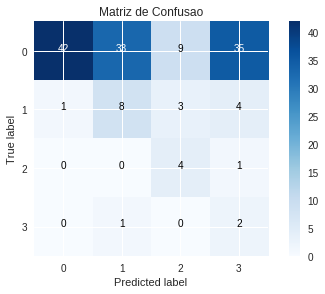

Resampling
accuracy: 0.391608391608
precision: [ 0.98  0.19  0.25  0.05]
recall: [ 0.35  0.5   0.8   0.67]
f1: [ 0.52  0.28  0.38  0.09]


In [12]:
# Aplicar classificador Logistic Regression
#clf = LogisticRegression(C = 0.01, penalty = 'l1')
#clf.fit(X_train_undersample,y_train_undersample.values.ravel())
dt = DecisionTreeClassifier()
clf = AdaBoostClassifier(n_estimators=100, base_estimator=dt, learning_rate=1)
clf.fit(X_train_undersample,y_train_undersample.values.ravel())
#prediction = clf.predict(X_test)

#pred_undersample = clf.predict(X_test_undersample.values)
pred_undersample = clf.predict(X_test.values)

# Computar matriz de confusão
#cnf_matrix = confusion_matrix(y_test_undersample,pred_undersample)
cnf_matrix = confusion_matrix(y_test,pred_undersample)
np.set_printoptions(precision=2)

#print("Recall: ", recall_score(y_test,prediction, average=None))

# Plotar Matriz de confusão
class_names = [0,1,2,3]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matriz de Confusao')

plt.show()

#print_results("Resampling", y_test_undersample,pred_undersample)
print_results("Resampling", y_test,pred_undersample)

# Undersampling

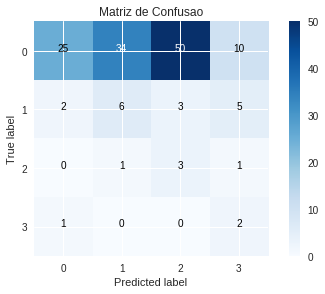

NearMiss
accuracy: 0.251748251748
precision: [ 0.89  0.15  0.05  0.11]
recall: [ 0.21  0.38  0.6   0.67]
f1: [ 0.34  0.21  0.1   0.19]


In [13]:
clf = RandomForestClassifier(random_state=42)
nearmiss_pipeline = make_pipeline_imb(NearMiss(random_state=42), clf)
nearmiss_model = nearmiss_pipeline.fit(X_train, y_train)
nearmiss_prediction = nearmiss_model.predict(X_test)

# Computar matriz de confusão
cnf_matrix = confusion_matrix(y_test,nearmiss_prediction)
np.set_printoptions(precision=2)

# Plotar Matriz de confusão
class_names = [0,1,2,3]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matriz de Confusao')

plt.show()

#Recall, precision, F1, accuracy
print_results("NearMiss", y_test,nearmiss_prediction)

In [14]:
#Informação sobre o modelo
X_nearmiss, y_nearmiss = NearMiss().fit_sample(X_all, y_all)
print("NearMiss data distribution: {}".format(Counter(y_nearmiss)))

NearMiss data distribution: Counter({0: 10, 1: 10, 2: 10, 3: 10})


In [15]:
#Pipeline Score
print('NearMiss Pipeline Score {}'.format(nearmiss_pipeline.score(X_test, y_test)))

NearMiss Pipeline Score 0.251748251748


# SMOTE imblearn

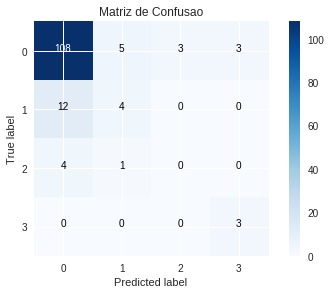

SMOTE
accuracy: 0.804195804196
precision: [ 0.87  0.4   0.    0.5 ]
recall: [ 0.91  0.25  0.    1.  ]
f1: [ 0.89  0.31  0.    0.67]


In [16]:
clf = RandomForestClassifier(random_state=42)

smote_pipeline = make_pipeline_imb(SMOTE(random_state=2), clf)
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

# Computar matriz de confusão
cnf_matrix = confusion_matrix(y_test,smote_prediction)
np.set_printoptions(precision=2)

# Plotar Matriz de confusão
class_names = [0,1,2,3]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matriz de Confusao')

plt.show()

#Recall, precision, F1, accuracy
print_results("SMOTE", y_test,smote_prediction)

In [17]:
#Informação sobre SMOTE
X_smote, y_smote = SMOTE().fit_sample(X_all, y_all)
print("SMOTE data distribution: {}".format(Counter(y_smote)))

SMOTE data distribution: Counter({0: 394, 1: 394, 2: 394, 3: 394})


In [18]:
#Relatório
print(classification_report_imbalanced(y_test, smote_prediction))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.91      0.33      0.89      0.61      0.38       119
          1       0.40      0.25      0.95      0.31      0.60      0.35        16
          2       0.00      0.00      0.98      0.00      0.00      0.00         5
          3       0.50      1.00      0.98      0.67      0.71      0.48         3

avg / total       0.78      0.80      0.44      0.79      0.59      0.37       143



In [19]:
#Pipeline
print('NearMiss Pipeline Score {}'.format(nearmiss_pipeline.score(X_test, y_test)))

NearMiss Pipeline Score 0.251748251748


# ADASYN imblearn

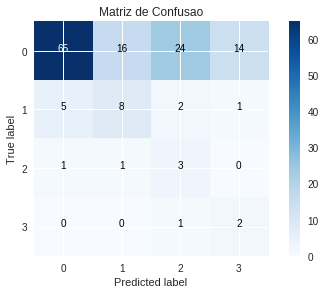

ADASYN
accuracy: 0.545454545455
precision: [ 0.92  0.32  0.1   0.12]
recall: [ 0.55  0.5   0.6   0.67]
f1: [ 0.68  0.39  0.17  0.2 ]


In [20]:
clf = LinearSVC()
adasyn_pipeline = make_pipeline_imb(ADASYN(random_state=4),clf)
adasyn_model = adasyn_pipeline.fit(X_train, y_train)
adasyn_prediction = adasyn_model.predict(X_test)

# Computar matriz de confusão
cnf_matrix = confusion_matrix(y_test,adasyn_prediction)
np.set_printoptions(precision=2)

# Plotar Matriz de confusão
class_names = [0,1,2,3]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matriz de Confusao')

plt.show()

#Recall, precision, F1, accuracy
print_results("ADASYN", y_test,adasyn_prediction)

# RandomUndersampler

In [21]:
from imblearn.under_sampling import RandomUnderSampler

print "X_train.shape[0] = {0} e X_test.shape[0] = {1}".format(X_train.shape[0], X_test.shape[0])

# Apenas para contar quantos elementos temos por classe no y_train original
y_train_dist_original = y_train.groupby(y_train).size()

# Mostra a quantidade de instancias por classe e em seguida o ratio
print "y_train distribuicao de classes original (valores absolutos) = {0}".format(y_train_dist_original)
print "y_train distribuicao de classes original (ratio) = {0}".format(y_train_dist_original/y_train.shape[0])

# Aqui começa a parte importante: criado o objeto rus do tipo RandomUnderSampler. 
#Note como o ratio e especificado para ele por meio do parametro ratio usando um dicionario. 
#Por que? A forma como foi feito é a certa sempre? 
#Nao existe uma resposta unica, o numero de instancias para corretamente representar uma classe 
#varia de problema para problema, logo aqui surge um local para refinar o modelo, isto e, 
#tentar varias combinacoes de random under sampling para cada classe (ou seja, é um hiperparametro a ser refinado).

# Dica: Fique variando os valores para 0, 1, 2 e 3 e perceba as variacoes na decision tree treinada 
#com o x_train_resampled
rus = RandomUnderSampler(return_indices=True, ratio={ 0: y_train_dist_original[0]/22, 
                                                    1: y_train_dist_original[1]/3, 
                                                    2: y_train_dist_original[2], 
                                                    3: y_train_dist_original[3]})
X_train_resampled, y_train_resampled, idx_train_resampled = rus.fit_sample(X_train, y_train)
# Apenas para mostrar a distribuicao do treinamento apos o resample
unique, counts = np.unique(y_train_resampled, return_counts=True)
print dict(zip(unique, counts))

X_train.shape[0] = 332 e X_test.shape[0] = 143
y_train distribuicao de classes original (valores absolutos) = Thrombosis
0    275
1     38
2     12
3      7
Name: Thrombosis, dtype: int64
y_train distribuicao de classes original (ratio) = Thrombosis
0    0.828313
1    0.114458
2    0.036145
3    0.021084
Name: Thrombosis, dtype: float64
{0: 12, 1: 12, 2: 12, 3: 7}


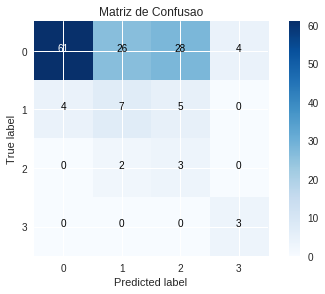

Decision Tree + Random Undersampling
accuracy: 0.517482517483
precision: [ 0.94  0.2   0.08  0.43]
recall: [ 0.51  0.44  0.6   1.  ]
f1: [ 0.66  0.27  0.15  0.6 ]


In [22]:
# Exemplo de treinamento e teste usando os dados submetidos a resampling

decisionTree = DecisionTreeClassifier()
decisionTree = AdaBoostClassifier(n_estimators=150, base_estimator=decisionTree, learning_rate=1)
dtf = decisionTree.fit(X_train_resampled, y_train_resampled)
pred_dtf = dtf.predict(X_test.values)

dtf_matrix = confusion_matrix(y_test, pred_dtf)
# Plotar Matriz de confusão
plt.figure()
plot_confusion_matrix(dtf_matrix, classes=[0,1,2,3], title='Matriz de Confusao')
plt.show()
print_results("Decision Tree + Random Undersampling", y_test, pred_dtf)